In [ ]:
from probatus.feature_elimination import ShapRFECV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut
from sklearn.model_selection import RepeatedKFold, cross_val_predict, cross_val_score
from BorutaShap import BorutaShap
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [ ]:
comorbidity_data = pd.read_csv('../data/processed_data/icd10_data_scaled.csv')
comorbidity_data = comorbidity_data[comorbidity_data.columns[1:]].drop(['Deaths', 'Active', 'Recovered'], axis=1)
comorbidity_data.head()

,code,"Endocrine, nutritional and metabolic diseases",Mental and behavioural disorders,Diseases of the nervous system,Diseases of the eye and adnexa and ear and mastoid process,Diseases of the circulatory system,Diseases of the respiratory system,Diseases of the digestive system,Diseases of the skin and subcutaneous tissue,Diseases of the musculoskeletal system and connective tissue,Diseases of the genitourinary system,"Pregnancy, childbirth and the puerperium",Certain conditions originating in the perinatal period,"Congenital malformations, deformations and chromosomal abnormalities","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",External causes of morbidity and mortality,infectious and parasitic diseases,Neoplasms,Country
0,1125,0.116819,0.003982,0.029111,0.358620,0.317068,0.106863,0.528042,0.099971,0.018798,0.302565,0.212921,0.186310,0.715048,0.498261,0.213145,0.204136,0.056119,Egypt
1,1300,0.020303,0.000613,0.000982,0.000000,0.004010,0.002546,0.004058,0.012974,0.003137,0.002798,0.010916,0.006106,0.009091,0.001477,0.005225,0.003640,0.002076,Mauritius
2,1310,0.025356,0.001458,0.006734,0.037462,0.012426,0.006090,0.013126,0.015431,0.008845,0.019342,0.056512,0.181005,0.071820,0.124645,0.024429,0.018527,0.008840,Morocco
3,1430,0.254980,0.013513,0.057587,0.415203,0.095107,0.118104,0.115927,0.189757,0.101523,0.126320,0.498899,0.433257,0.192121,0.481148,0.150137,0.200390,0.069400,South Africa
4,1520,0.016797,0.000729,0.002674,0.004683,0.006896,0.003377,0.006622,0.016869,0.003148,0.006662,0.014117,0.053596,0.046754,0.032037,0.007470,0.008149,0.004877,Tunisia


In [ ]:
control = pd.read_csv('../data/raw_data/control/regression_targets.csv')
targets = control[['Country', 'Deaths', 'Confirmed', 'Active', 'Recovered']]
print(f'Missing values: {targets.isnull().sum()}')
targets.head()

Missing values: Country      0
Deaths       6
Confirmed    6
Active       8
Recovered    6
dtype: int64


,Country,Deaths,Confirmed,Active,Recovered
0,Afghanistan,0.006186,0.142134,0.012574,0.123374
1,Albania,0.050951,2.967301,1.123714,1.792636
2,Algeria,0.006558,0.244897,0.070767,0.167572
3,Angola,0.001461,0.061687,0.003419,0.056808
4,Antigua and Barbuda,0.007143,0.293878,0.095918,0.190816


In [ ]:
targets.dropna(axis=0, inplace=True)

In [ ]:
comorbidity_data = comorbidity_data.merge(targets, on='Country', how='inner')

In [ ]:
label_values = ['Deaths', 'Active', 'Recovered', 'Confirmed']
features_comorbidity = comorbidity_data.columns.drop(label_values)
features_comorbidity = features_comorbidity.drop(['Country', 'code'])

In [ ]:
X_comorbidity = comorbidity_data[features_comorbidity]
Y_comorbidity = comorbidity_data[label_values]

In [ ]:
selected_features_comorbidity = pd.read_csv('../data/feature_selection/selected_features_rfe_shap_comorbidity.csv')
selected_features_comorbidity = selected_features_comorbidity['selected_features']

In [ ]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBRegressor(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=LeaveOneOut())
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [ ]:
def cross_validation_predictions(regressor, data, target, folds=5):
  scores = {}
  n_folds = RepeatedKFold(n_splits=folds, n_repeats=5, random_state=0)
  scores['neg_mean_absolute_error'] = cross_val_score(regressor, data, target, cv=n_folds, scoring='neg_mean_absolute_error').mean()
  scores['neg_median_absolute_error'] = cross_val_score(regressor, data, target, cv=n_folds, scoring='neg_median_absolute_error').mean()
  scores['neg_mean_squared_error'] = cross_val_score(regressor, data, target, cv=n_folds, scoring='neg_mean_squared_error').mean()
  scores['r2'] = cross_val_score(regressor, data, target, cv=n_folds, scoring='r2').mean()
  predictions = cross_val_predict(regressor, data, target, cv=LeaveOneOut())
  return scores, predictions

In [ ]:
PARAMS = {
    'max_depth': [2, 3, 5, 7, 10],
    'min_child_weight': [3, 4, 5, 6],
    'learning_rate': [0.003, 0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 75, 100, 150, 200, 250, 300, 350]
}

In [ ]:
comorbidity_params, comorbidity_score = hyper_parameter_search(X_comorbidity[selected_features_comorbidity], Y_comorbidity['Deaths'], PARAMS)

In [ ]:
print(f'best parameters: {comorbidity_params}')
print(f'score: {comorbidity_score}')

best parameters: {'gamma': 0, 'learning_rate': 0.25, 'max_depth': 2, 'min_child_weight': 6, 'n_estimators': 35}
score: -0.03724667089595838


In [ ]:
xgb_comorbidity = XGBRegressor(gamma = comorbidity_params['gamma'],
                               learning_rate = comorbidity_params['learning_rate'],
                               max_depth = comorbidity_params['max_depth'],
                               min_child_weight = comorbidity_params['min_child_weight'],
                               n_estimators = comorbidity_params['n_estimators'])

In [ ]:
scores_comorbidity, predictions_comorbidity = cross_validation_predictions(xgb_comorbidity, X_comorbidity[selected_features_comorbidity],
                                                             Y_comorbidity['Deaths'])

[23:01:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
scores_comorbidity

{'neg_mean_absolute_error': -0.03945562276883487,
 'neg_mean_squared_error': -0.0023662109880030983,
 'neg_median_absolute_error': -0.033193097238266224,
 'r2': 0.02881826723655807}

In [ ]:
abs_difs_comorbidity = np.abs(predictions_comorbidity - Y_comorbidity['Deaths'].values)

In [ ]:
ordered_values = []
for i in range(len(abs_difs_comorbidity)):
  node = {}
  node['predicted'] = predictions_comorbidity[i]
  node['actual'] = Y_comorbidity['Deaths'].values[i]
  node['error'] = abs_difs_comorbidity[i]
  node['country'] = comorbidity_data.iloc[i].Country
  ordered_values.append(node)

ordered_values.sort(key = lambda item: item['error'])

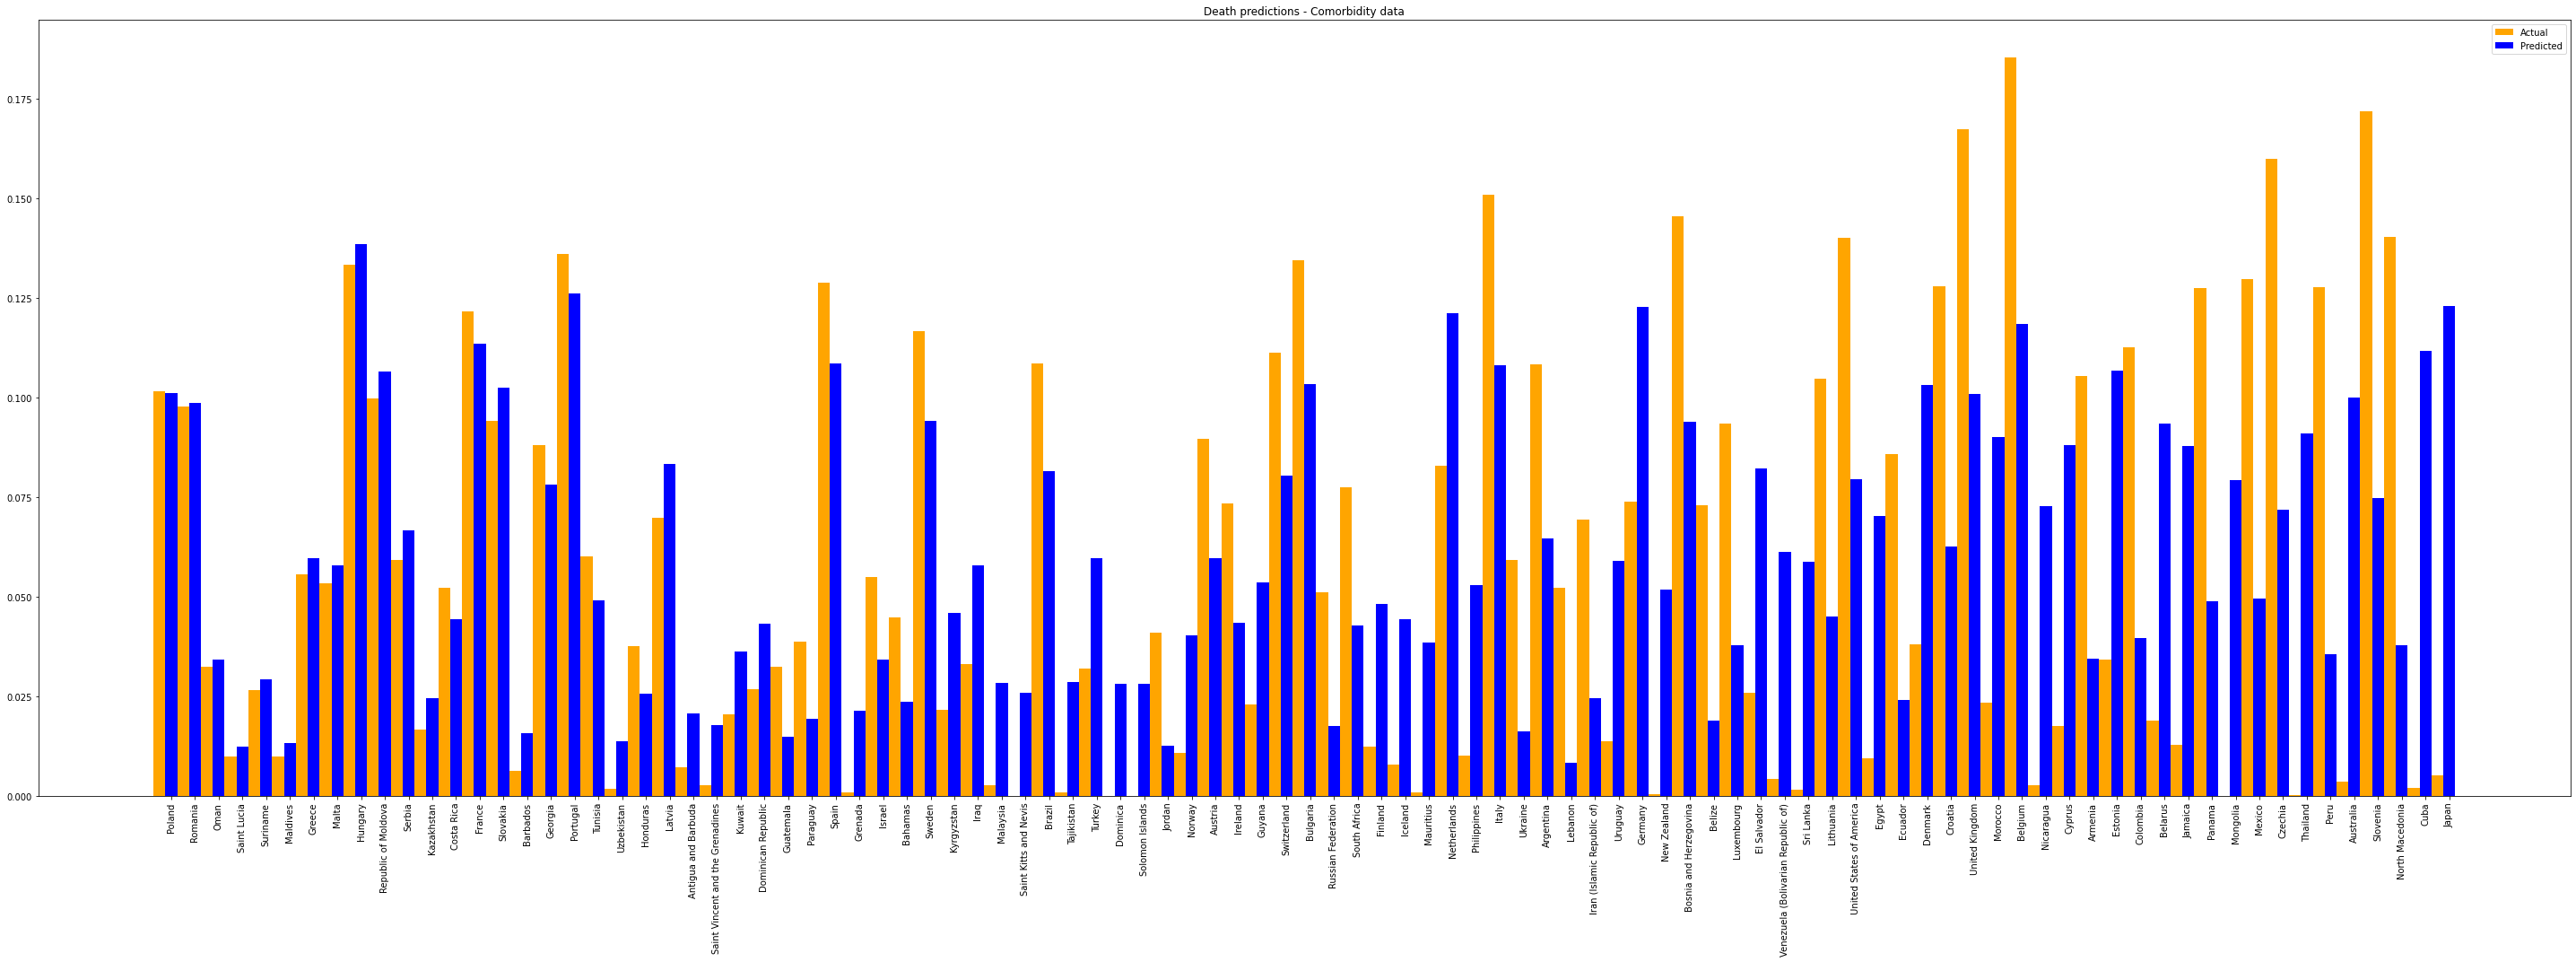

In [ ]:
x = np.arange(1, len(X_comorbidity) + 1)
plt.figure(figsize=(40, 15))
countries = []
for i, elem in enumerate(ordered_values):
  plt.bar(x[i]-0.5, elem['actual'], width=0.5, color='orange', align='center', label='True values')
  plt.bar(x[i], elem['predicted'], color='blue', label='Predicted values', width = 0.5, align='center')
  countries.append(elem['country'])
plt.xticks(x, countries, rotation=90)
plt.title('Death predictions - Comorbidity data')
plt.legend(['Actual', 'Predicted'])
plt.tight_layout()

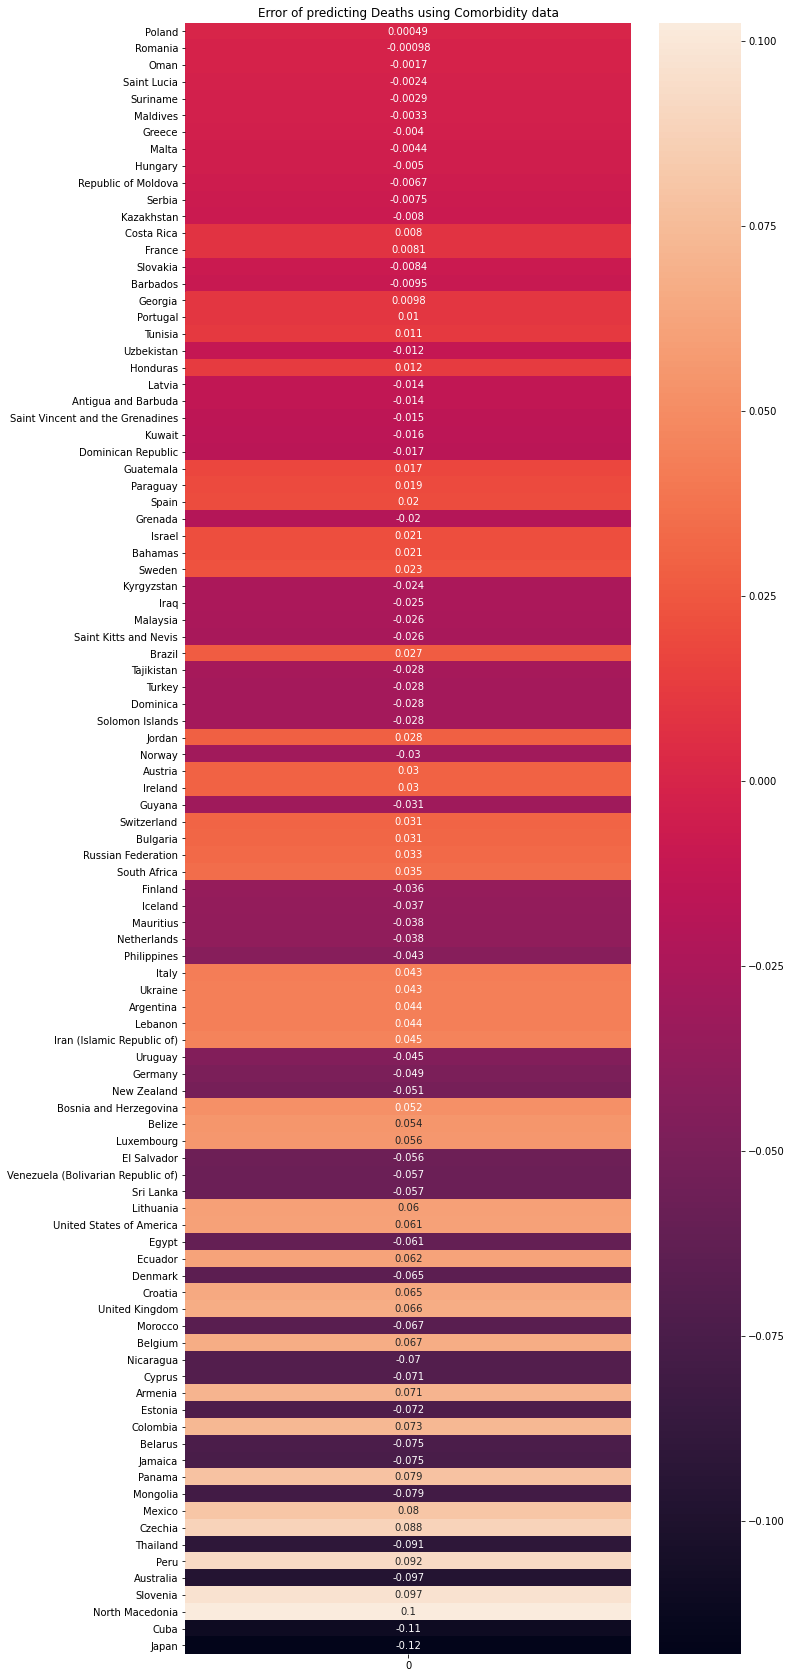

In [ ]:
errors_comorbidity = [[val['actual'] - val['predicted']] for val in ordered_values]
countries_comorbidity = [val['country'] for val in ordered_values]

plt.figure(figsize=(10, 30))
sns.heatmap(errors_comorbidity, annot=True, yticklabels=countries_comorbidity)
plt.title("Error of predicting Deaths using Comorbidity data")
plt.savefig("Error of predicting Deaths using comorbidity data.png")